# Visualize Logistic Regression

The logistic regression was fitted on the data in the [11-mw-logistic-regression](11-mw-logistic-regression.ipynb). There, a simple visualization was also already present. Here, we try to make the plot publication-ready and to integrate it into a toolbox-use, where a new patient can be added and a probability of being correct can be computed based on the intercept and slope of the previously fitted logistic function.

### import modules

In [1]:
import os
import pickle

import numpy as np
import pandas as pd

from sklearn import metrics, linear_model

from scipy import stats

from PIL import Image

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
sns.set_context('poster')
sns.set_style('ticks')

In [3]:
# after converstion to .py, we can use __file__ to get the module folder
try:
    thisDir = os.path.realpath(__file__)
# in notebook form, we take the current working directory (we need to be in 'notebooks/' for this!)
except:
    thisDir = '.'
# convert relative path into absolute path, so this will work with notebooks and py modules
supDir = os.path.abspath(os.path.join(os.path.dirname(thisDir), '..'))

supDir

'/data/martin/volume-wise-language'

### get stored data

In [4]:
groupdata_filename = '../data/processed/csv/withinconclusive_prediction_df.csv'

In [5]:
#groupdata_filename = os.path.join(supDir,'models','withinconclusive_prediction_df.csv')

In [6]:
prediction_df = pd.read_csv(groupdata_filename,index_col=[0,1],header=0)

In [ ]:
prediction_df.tail()

### color settings

In [8]:
colors_file = os.path.join(supDir,'models','colors.p')
with open(colors_file, 'rb') as f:
    color_dict = pickle.load(f)
    
my_cols = {}
for i, j in zip(['red', 'blue', 'yellow'], ['left', 'right', 'bilateral']):
    my_cols[j] = color_dict[i]

## Logistic Function Fit

In [9]:
def make_arrays(prediction_df):
    X = prediction_df.loc[:, 'highest_num'].values.reshape(-1, 1)
    y = prediction_df.loc[:, 'hit'].values
    y_labels = prediction_df.loc[:, 'true_class']
    return X, y, y_labels

In [10]:
X, y, y_labels = make_arrays(prediction_df)

In [11]:
X.shape, y.shape, y_labels.shape

((96, 1), (96,), (96,))

### add jitter to y-axis

In [12]:
def make_jitter(y, j=3000):

    n = y.shape[0]
    rand_shifts = np.random.randint(-100, 100, size=n)
    rand_scale_shifts = rand_shifts / float(j)
    y_jitter = (y.T + rand_scale_shifts).T

    return y_jitter

In [13]:
y_jitter = make_jitter(y)

### example figure

Without and with jitter

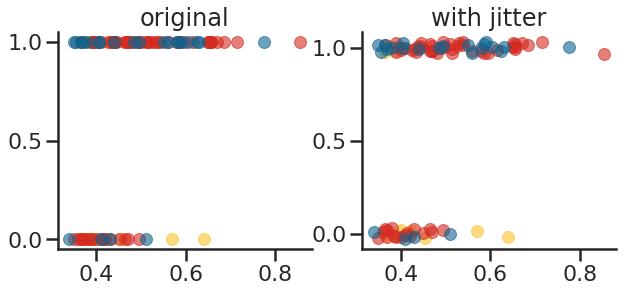

In [14]:
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(10,4))
for x in range(X.shape[0]):   
    ax1.plot(X[x],y[x],'o',c=my_cols[y_labels[x]],alpha=0.6)
ax1.set_title('original')
for x in range(X.shape[0]):   
    ax2.plot(X[x],y_jitter[x],'o',c=my_cols[y_labels[x]],alpha=0.6)
ax2.set_title('with jitter')
sns.despine()
plt.show()

### re-load stored logistic regression

In [15]:
logclf_file = os.path.join(supDir,'models','log_clf.p')
with open(logclf_file, 'rb') as f:
    clf = pickle.load(f)

#### Example behavior:

In [16]:
clf

LogisticRegression(C=100000.0, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [17]:
clf.predict_proba([[0.1]])

array([[0.96280095, 0.03719905]])

### plot logistic regression

In [18]:
def make_log_curve(clf):
    
    def log_func(x):
        return 1 / (1 + np.exp(-x))

    curve_X = np.linspace(0, 1, 1000)
    curve_y = np.array(
        [log_func(i * clf.coef_ + clf.intercept_)[-1][-1] for i in curve_X])

    return curve_X, curve_y

In [19]:
curve_X, curve_y = make_log_curve(clf)

In [20]:
curve_X.shape,curve_y.shape

((1000,), (1000,))

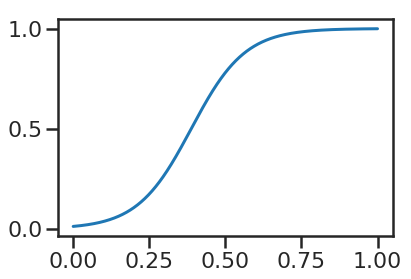

In [21]:
plt.plot(curve_X,curve_y)

## combine into one plot

### function to wrap plotting of raw data and fitted function

In [22]:
def make_log_plot(X, y, y_labels, clf, ax, color_dict=color_dict):

    labels = []
    for x in range(X.shape[0]):
        this_label = y_labels[x]
        if this_label not in labels:
            ax.plot(X[x],y[x],'o',c=my_cols[this_label],alpha=0.4,label=this_label)
            labels.append(this_label)
        else:
            ax.plot(X[x],y[x],'o',c=my_cols[this_label],alpha=0.4)

    curve_X, curve_y = make_log_curve(clf)
    ax.plot(curve_X, curve_y, alpha=0.6, c='k')

    sns.despine(trim=True)
    
    return ax

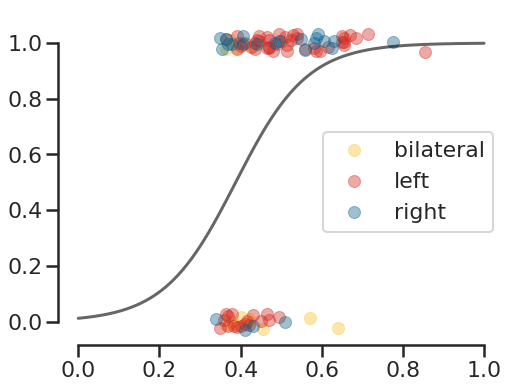

In [23]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
ax = make_log_plot(X, y_jitter, y_labels, clf, ax)
plt.legend()
plt.show()

### get inverse

In [24]:
def get_brute_force_x(y,clf):
    
    my_list = np.linspace(0,1,100000)
    
    def get_diff(x,y,clf):
        return abs(clf.predict_proba(x)[-1][-1]-y)
    
    my_vals = np.array([get_diff(x,y,clf) for x in my_list ])

    my_min = np.min(my_vals)
    
    my_where = np.where(my_vals==my_min)[-1]
    
    my_x = my_list[my_where][-1]
    
    return my_x

#### Example:

In [25]:
my_x = 0.5

In [26]:
my_y = clf.predict_proba(my_x)[-1][-1]
my_y

0.7801756190738435

In [27]:
x_again = get_brute_force_x(my_y,clf)
x_again

0.5000050000500005

### plot everything

In [28]:
def make_group_log_plot(prediction_df,clf,ax,y_criterion=0.9):
    
    X, y, y_labels = make_arrays(prediction_df)
    y_jitter = make_jitter(y)

    ax = make_log_plot(X, y_jitter, y_labels, clf, ax)

    x_necessary = get_brute_force_x(y_criterion,clf)

    ax.axhline(y_criterion,linestyle=':',color='k')
    ax.axvline(x_necessary,linestyle=':',color='k')
    
    ax.set_yticks([0, y_criterion, 1])
    ax.set_xticks([0,x_necessary.round(2),1])

    ax.set_xlabel('proportion agreeing')
    ax.set_ylabel('probability correct')
    
    return ax

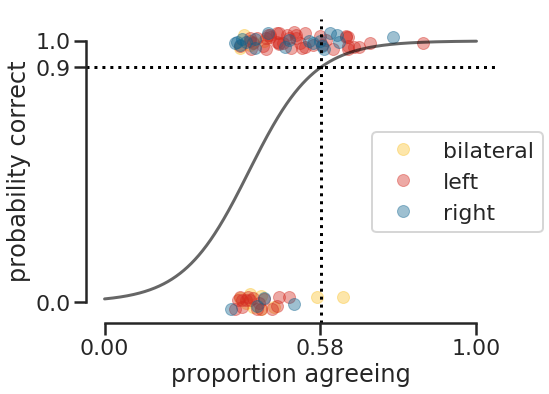

In [29]:
fig = plt.figure(figsize=(8, 6))

ax = plt.subplot(111)
ax = make_group_log_plot(prediction_df,clf,ax,y_criterion=0.9)    

plt.legend(loc=(0.7,0.3))
plt.tight_layout()
plt.savefig('../reports/figures/15-logistic-regression.png',dpi=300,bbox_inches='tight')

plt.show()

### combine with prediction space figure

In [30]:
sns.set_style('dark')

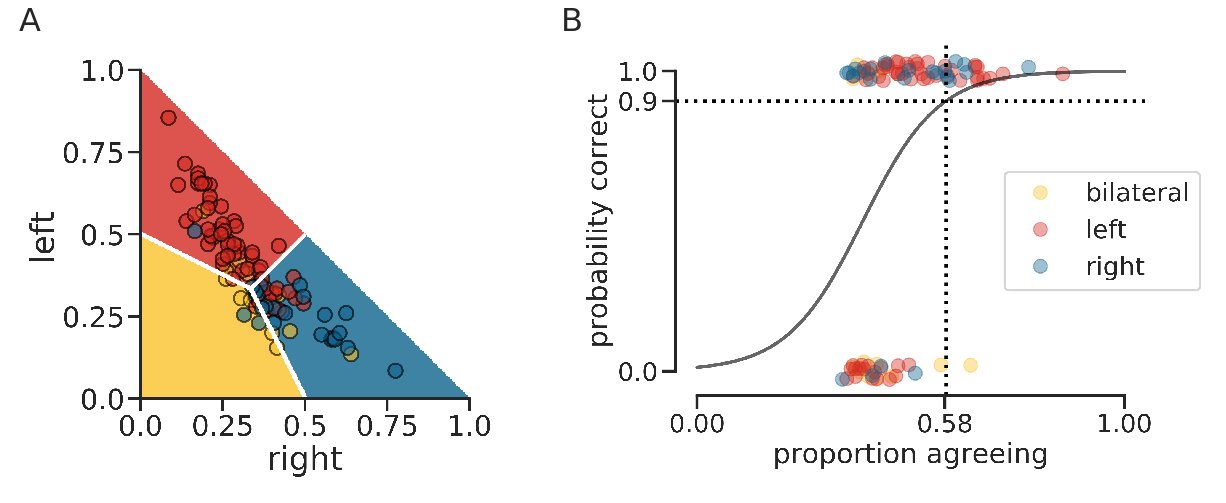

In [31]:
fig = plt.figure(figsize=(16,6))

ax1 = fig.add_axes([0,0.985,0.9,1], xticklabels=[], yticklabels=[])
ax1.imshow(Image.open('../reports/figures/14-prediction-space.png'))

ax2 = fig.add_axes([0.5, 1, 1, 1.025], xticklabels=[], yticklabels=[])
ax2.imshow(Image.open('../reports/figures/15-logistic-regression.png'))

plt.text(0,1.05, 'A',transform=ax1.transAxes, fontsize=32)
plt.text(1.13,1.05, 'B',transform=ax1.transAxes, fontsize=32)

plt.savefig('../reports/figures/15-space-and-log.png',dpi=300,bbox_inches='tight')
plt.show()

In [32]:
sns.set_style('ticks')

### get probability of being correct for new prediciton

In [33]:
p_name = 'pat###'

In [34]:
p_count_df = pd.read_csv('../data/processed/csv/%s_counts_df.csv'%p_name,index_col=[0,1],header=0)

In [35]:
p_prediction_df = p_count_df/p_count_df.sum(axis=1).values[-1]

In [ ]:
p_prediction_df

In [ ]:
p_group = p_prediction_df.idxmax(axis=1).values[-1]
p_highest = p_prediction_df.max(axis=1)
print(p_group,p_highest)

In [38]:
def make_single_log_plot(p_df,group_df,clf,ax):
    
    x_value = p_df.max(axis=1).values[-1]
    y_pred = clf.predict_proba(np.array([[x_value]]))[-1][-1]
    y_label = p_df.idxmax(axis=1).values[-1]
    
    ax.plot(x_value.round(2),[y_pred.round(2)],'o',c=my_cols[y_label])
    
    X, y, y_labels = make_arrays(group_df)
    y_jitter = make_jitter(y)

    ax = make_log_plot(X, y_jitter, y_labels, clf, ax)

    ax.axhline(y_pred.round(2),linestyle=':',color='k')
    ax.axvline(x_value.round(2),linestyle=':',color='k')
    
    ax.set_yticks([0, y_pred.round(2), 1])
    ax.set_xticks([0,x_value.round(2),1])
    
    ax.set_yticklabels([None,y_pred.round(2),None])
    ax.set_xticklabels([None,x_value.round(2),None])
    
    ax.set_xlabel('proportion agreeing')
    ax.set_ylabel('probability correct')
    return ax

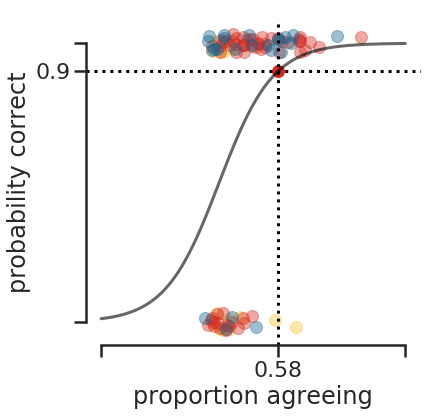

In [39]:
fig = plt.figure(figsize=(6, 6))

ax = plt.subplot(111)
ax = make_single_log_plot(p_prediction_df,prediction_df,clf,ax)    
plt.savefig('../examples/%s_logFunc.png'%p_name,dpi=300,bbox_inches='tight')
plt.show()

#### toolbox use

In [40]:
#def make_p(pFolder,pName,prediction_df=prediction_df,clf=clf):
#    
#    count_filename = os.path.join(pFolder,''.join([pName,'_counts_df.csv']))
#    p_count_df = pd.read_csv(count_filename,index_col=[0,1],header=0)
#    
#    p_prediction_df = p_count_df/p_count_df.sum(axis=1).values[-1]
#    
#    p_group = p_prediction_df.idxmax(axis=1).values[-1]
#    p_highest = p_prediction_df.max(axis=1)
#
#    fig = plt.figure(figsize=(6, 6))
#    with sns.axes_style("ticks"):
#        ax = plt.subplot(111)
#        ax = make_single_log_plot(p_prediction_df,prediction_df,clf,ax)    
#    out_name = os.path.join(pFolder,''.join([pName,'_logFunc.png']))
#    plt.savefig(out_name,dpi=300,bbox_inches='tight') 
#    plt.close()
#    
#    return out_name

### summary

The results show that we can achieve an accuracy of e.g. 0.9 if we only consider datasets with at least 0.58% concordant volumes. This should also allow to get a rough estimate of how likely one is to be correct, given the number of agreeing volumes of a new participant who is analyzed prospectively. 
While the relationship of n-volumes to p-correct seems rather simple, additional complexity could (and maybe should) be added. For example a conditional probability predicted class | true diagnosis or the conditional probability true diagnosis | predicted class could be modeled.


**************

< [Previous](14-mw-prediction-space.ipynb) | [Contents](00-mw-overview-notebook.ipynb) | [Next >](16-mw-individual-patients-plot.ipynb)